# Process Data

This notebook goes through the steps to process raw .pkl files into a usable format by
1. Extracting data for each earthquake as well as earthquake metadata
2. Selecting a subset of stations out of all those with data to perform analysis
3. Compress data via subsampling


In [2]:
## Imports

import pickle
from pathlib import Path
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns; sns.set()
# matplotlib.rc('font', **{'size': 18})
import numpy as np
import json

In [3]:
load_path = '../data/Ridgecrest/'
data_dir = "../data/"
raw_path = os.path.join(data_dir, "raw")
meta_path = os.path.join(data_dir, "metadata")
relevant_path = os.path.join(data_dir, "acc", "relevant_stations")
compressed_path = os.path.join(data_dir, "acc", "compressed")

### Step-1: Extract data for earthquakes

#### Part a: Extract accelerations

In [3]:
def get_indices(station_start_time, earthquake_start_time, period = 6000, step=100, offset=15):
    start_idx = int(100*(earthquake_start_time - station_start_time)) - offset*step
    end_idx = start_idx + period
    return (start_idx, end_idx)


In [ ]:
input_dir = Path(load_path)

output_dir = Path(raw_path)
output_files = [os.path.split(f)[1].split('.')[0] for f in sorted(output_dir.glob("*.npy"))]
print(output_files)

if not os.path.exists(raw_path):
    os.mkdir(raw_path)

def np_from_pkl(data_path, save_path, period = 6000):
    input_dir = Path(data_path)
    sorted(input_dir.glob("*.pkl"))
    for f in tqdm(sorted(input_dir.glob("*.pkl"))):
#         print(f)
        day_id = os.path.split(f)[1].split('.')[0]
#         if day_id in output_files: 
#             print("File found for date: {}".format(day_id))
#             continue
        ## Iterating over pickles
        stations = []
        with open(f, 'rb') as fp:
            try:
                data = pickle.load(fp)
            except:
                print("Pickle Corrupted")
                print("Corrupted path: {}".format(f))
                continue
            num_stations, num_events = len(data['stations']), len(data['events'])
#             data_arr = np.zeros

            for station in data['stations']:
                events = []
                for event in data['events']:
                    start_idx, end_idx = get_indices(data['stations'][station]['starttime'], event['time'])
                    if (end_idx > len(data['stations'][station]['data']) - 1) or (start_idx < 0):
                        continue #skip event
                    events.append(np.transpose(data['stations'][station]['data'][start_idx: end_idx], (1, 0)))
                events = np.array(events)
#                 print("events shape", events.shape)
                stations.append(events)
        save_arr = np.array(stations) 
#         print("station shape: ", save_arr.shape)
        filename = day_id + ".npy"
        np.save(os.path.join(save_path, filename), save_arr) 
        
np_from_pkl(load_path, raw_path)


#### Part b: Extract metadata

In [ ]:
## Reads through pickles. Saves stations and events (w/o the big boy quake data)    

if not os.path.exists(meta_path):
    os.mkdir(meta_path)
    
def save_station_and_events(data_path, save_path):
    dropped = []
    input_dir = Path(data_path)
    sorted(input_dir.glob("*.pkl"))
    for f in tqdm(sorted(input_dir.glob("*.pkl"))):
        print(f)
        day_id = os.path.split(f)[1].split('.')[0]
        ## Iterating over pickles
#         stations = []
        with open(f, 'rb') as fp:
            try:
                data = pickle.load(fp)
            except:
                print("Pickle Corrupted")
                print("Corrupted path: {}".format(f))
                continue
                
        first_stat = list(data['stations'].keys())[0]
        filename = day_id + "_meta.json"
                
        ## Idxs to keep
        idxs_to_keep = []
        for e, event in enumerate(data['events']):
            start_idx, end_idx = get_indices(data['stations'][first_stat]['starttime'], event['time'])
            if (end_idx > len(data['stations'][first_stat]['data']) - 1) or (start_idx < 0):
                ## Event was skipped
                pass
            else:
                idxs_to_keep.append(e)
        before = len(data['events'])
        data['events'] = [data['events'][idx] for idx in idxs_to_keep]
        after = len(data['events'])
        print("Num events dropped from date {}: {}".format(day_id, before - after))
        dropped.append(before - after)
        for station in data['stations']:
#             print(data['stations'][station].keys())
            for key in ['starttime', 'endtime', 'data']:
                del data['stations'][station][key]            
        for e, event in enumerate(data['events']):
            del data['events'][e]['time']
#         print(data)
        stations = np.array([stat for stat in data['stations'].keys()])
        print(stations)
        np.save(os.path.join(save_path, "{}_stations.npy".format(day_id)), stations)
        with open(os.path.join(save_path, filename), 'w') as fp:
            json.dump(data, fp)      
    with open(os.path.join(save_path, "dropped_events.txt"), 'w') as fp:
        fp.write(str(sum(dropped)) + '\n')
        for d in dropped:
            fp.write(str(d)+'\n')
        
save_station_and_events(load_path, meta_path)

#### Part c: Get shapes for all dates

In [14]:
files = [entry for entry in os.scandir(raw_path)]
print(len(files))

122


In [37]:
stations, events = [], []
for file in files:
#     print(np.load(os.path.join(data_path, file)).shape)
    temp = np.load(file)
    print(temp.shape)
    stations.append(temp.shape[0])
    events.append(temp.shape[1])
    del temp


(23, 94, 3, 6000)
(16, 3, 3, 6000)
(31, 267, 3, 6000)
(28, 250, 3, 6000)
(16, 12, 3, 6000)
(19, 1235, 3, 6000)
(31, 559, 3, 6000)
(30, 739, 3, 6000)
(33, 243, 3, 6000)
(27, 244, 3, 6000)
(16, 10, 3, 6000)
(29, 245, 3, 6000)
(16, 11, 3, 6000)
(26, 118, 3, 6000)
(31, 275, 3, 6000)
(25, 158, 3, 6000)
(16, 7, 3, 6000)
(32, 257, 3, 6000)
(29, 644, 3, 6000)
(34, 551, 3, 6000)
(16, 11, 3, 6000)
(29, 744, 3, 6000)
(31, 134, 3, 6000)
(24, 144, 3, 6000)
(26, 123, 3, 6000)
(16, 4, 3, 6000)
(32, 229, 3, 6000)
(29, 647, 3, 6000)
(27, 271, 3, 6000)
(21, 1335, 3, 6000)
(25, 99, 3, 6000)
(32, 315, 3, 6000)
(32, 836, 3, 6000)
(23, 83, 3, 6000)
(16, 2, 3, 6000)
(16, 5, 3, 6000)
(32, 731, 3, 6000)
(34, 545, 3, 6000)
(30, 251, 3, 6000)
(29, 462, 3, 6000)
(31, 357, 3, 6000)
(16, 6, 3, 6000)
(31, 233, 3, 6000)
(31, 290, 3, 6000)
(16, 15, 3, 6000)
(16, 6, 3, 6000)
(17, 1895, 3, 6000)
(16, 4, 3, 6000)
(16, 4, 3, 6000)
(31, 285, 3, 6000)
(31, 228, 3, 6000)
(24, 131, 3, 6000)
(32, 294, 3, 6000)
(16, 20, 3, 6000

In [39]:
dates = [file.name for file in files]
stat_evs = zip(stations, events)

shapes = [(s, v, 3, 6000) for s, v in stat_evs]
mapping = dict(zip(dates, shapes))
print(mapping)

with open(os.path.join(meta_path, 'date_to_shape.json'), 'w') as fp:
    json.dump(mapping, fp)

{'2019-09-22.npy': (23, 94, 3, 6000), '2019-06-12.npy': (16, 3, 3, 6000), '2019-08-25.npy': (31, 267, 3, 6000), '2019-07-31.npy': (28, 250, 3, 6000), '2019-07-02.npy': (16, 12, 3, 6000), '2019-07-07.npy': (19, 1235, 3, 6000), '2019-07-19.npy': (31, 559, 3, 6000), '2019-07-17.npy': (30, 739, 3, 6000), '2019-08-15.npy': (33, 243, 3, 6000), '2019-08-04.npy': (27, 244, 3, 6000), '2019-06-10.npy': (16, 10, 3, 6000), '2019-08-10.npy': (29, 245, 3, 6000), '2019-06-26.npy': (16, 11, 3, 6000), '2019-09-30.npy': (26, 118, 3, 6000), '2019-08-26.npy': (31, 275, 3, 6000), '2019-09-13.npy': (25, 158, 3, 6000), '2019-06-29.npy': (16, 7, 3, 6000), '2019-08-13.npy': (32, 257, 3, 6000), '2019-07-26.npy': (29, 644, 3, 6000), '2019-07-21.npy': (34, 551, 3, 6000), '2019-06-08.npy': (16, 11, 3, 6000), '2019-07-15.npy': (29, 744, 3, 6000), '2019-09-06.npy': (31, 134, 3, 6000), '2019-09-11.npy': (24, 144, 3, 6000), '2019-09-26.npy': (26, 123, 3, 6000), '2019-06-04.npy': (16, 4, 3, 6000), '2019-08-16.npy': (32

#### Part d: Count number of quakes per station

In [11]:
station_files = [entry.name for entry in Path(meta_path).glob("*.npy") if "stations" in entry.name]
print(station_files)

['2019-09-18_stations.npy', '2019-09-23_stations.npy', '2019-08-03_stations.npy', '2019-08-31_stations.npy', '2019-07-17_stations.npy', '2019-06-03_stations.npy', '2019-06-26_stations.npy', '2019-07-16_stations.npy', '2019-09-29_stations.npy', '2019-06-17_stations.npy', '2019-06-04_stations.npy', '2019-09-28_stations.npy', '2019-07-02_stations.npy', '2019-09-25_stations.npy', '2019-06-29_stations.npy', '2019-06-08_stations.npy', '2019-09-06_stations.npy', '2019-09-14_stations.npy', '2019-06-01_stations.npy', '2019-07-05_stations.npy', '2019-09-16_stations.npy', '2019-07-14_stations.npy', '2019-06-13_stations.npy', '2019-08-14_stations.npy', '2019-09-17_stations.npy', '2019-09-27_stations.npy', '2019-08-04_stations.npy', '2019-09-22_stations.npy', '2019-07-18_stations.npy', '2019-07-30_stations.npy', '2019-08-27_stations.npy', '2019-09-15_stations.npy', '2019-09-05_stations.npy', '2019-06-06_stations.npy', '2019-09-12_stations.npy', '2019-09-21_stations.npy', '2019-06-09_stations.npy', 

In [12]:
stations = []
for file in station_files:
    stations.append(np.load(os.path.join(meta_path, file)))
    
# print(stations)

In [28]:
counts = {}
for v in stations:
    for stat in v:
        if stat not in counts:
            counts[stat] = 0
print("Stations: ", counts)
print(len(counts))

Stations:  {'CI.CCC.': 0, 'CI.DTP.': 0, 'CI.JRC2.': 0, 'CI.LRL.': 0, 'CI.MPM.': 0, 'CI.SLA.': 0, 'CI.SRT.': 0, 'CI.TOW2.': 0, 'CI.WBM.': 0, 'CI.WCS2.': 0, 'CI.WMF.': 0, 'CI.WNM.': 0, 'CI.WRC2.': 0, 'CI.WRV2.': 0, 'CI.WVP2.': 0, 'GS.CA01.20': 0, 'GS.CA03.20': 0, 'GS.CA05.20': 0, 'GS.CA06.20': 0, 'GS.CA07.00': 0, 'GS.CA08.00': 0, 'GS.CA09.00': 0, 'GS.CA10.00': 0, 'NP.5419.10': 0, 'ZY.SV01.': 0, 'ZY.SV06.': 0, 'ZY.SV08.': 0, 'CI.CLC.': 0, 'GS.CA04.20': 0, 'ZY.SV02.': 0, 'ZY.SV03.': 0, 'ZY.SV04.': 0, 'GS.CA02.20': 0, 'ZY.SV05.': 0, 'ZY.SV07.': 0, 'NP.5419.': 0}
36


In [29]:
date_to_shape = None
with open(os.path.join(meta_path, 'date_to_shape.json'), 'r') as json_file:
    date_to_shape = json.load(json_file)
    dates, shapes = zip(*date_to_shape.items())
    dates, shapes = list(dates), list(shapes)

# dates = [dates[i].split('.')[0] for i in range(len(dates))]
print(dates)

['2019-09-22.npy', '2019-06-12.npy', '2019-08-25.npy', '2019-07-31.npy', '2019-07-02.npy', '2019-07-07.npy', '2019-07-19.npy', '2019-07-17.npy', '2019-08-15.npy', '2019-08-04.npy', '2019-06-10.npy', '2019-08-10.npy', '2019-06-26.npy', '2019-09-30.npy', '2019-08-26.npy', '2019-09-13.npy', '2019-06-29.npy', '2019-08-13.npy', '2019-07-26.npy', '2019-07-21.npy', '2019-06-08.npy', '2019-07-15.npy', '2019-09-06.npy', '2019-09-11.npy', '2019-09-26.npy', '2019-06-04.npy', '2019-08-16.npy', '2019-07-18.npy', '2019-08-05.npy', '2019-07-08.npy', '2019-09-20.npy', '2019-08-12.npy', '2019-07-13.npy', '2019-09-16.npy', '2019-06-03.npy', '2019-06-30.npy', '2019-07-14.npy', '2019-07-22.npy', '2019-08-27.npy', '2019-07-25.npy', '2019-08-22.npy', '2019-06-19.npy', '2019-08-31.npy', '2019-08-11.npy', '2019-06-06.npy', '2019-06-27.npy', '2019-07-06.npy', '2019-06-07.npy', '2019-06-20.npy', '2019-08-24.npy', '2019-08-20.npy', '2019-09-23.npy', '2019-08-14.npy', '2019-06-16.npy', '2019-08-28.npy', '2019-09-

In [30]:
print(shapes[0], stations[0])

[23, 94, 3, 6000] ['CI.CCC.' 'CI.DTP.' 'CI.JRC2.' 'CI.LRL.' 'CI.MPM.' 'CI.SLA.' 'CI.SRT.'
 'CI.TOW2.' 'CI.WBM.' 'CI.WCS2.' 'CI.WMF.' 'CI.WNM.' 'CI.WRC2.' 'CI.WRV2.'
 'CI.WVP2.' 'GS.CA01.20' 'GS.CA03.20' 'GS.CA05.20' 'GS.CA06.20'
 'GS.CA07.00' 'GS.CA08.00' 'GS.CA09.00' 'GS.CA10.00' 'NP.5419.10']


In [31]:
for s_idx, s in enumerate(shapes):
#     print(s[0])
#     print(s[0], stations[dates[s_idx]])
    num_events = s[1]
#     print(s_idx)
#     print(s[0], date_to_shape[dates[s_idx]][0])
    assert s[0] == date_to_shape[dates[s_idx]][0]

#     assert s[0] == stations[s_idx].shape[0]
    for stat in stations[s_idx]:
        counts[stat] += num_events
print(counts)

{'CI.CCC.': 35858, 'CI.DTP.': 35858, 'CI.JRC2.': 35206, 'CI.LRL.': 35858, 'CI.MPM.': 35858, 'CI.SLA.': 35858, 'CI.SRT.': 35858, 'CI.TOW2.': 35858, 'CI.WBM.': 35858, 'CI.WCS2.': 35858, 'CI.WMF.': 35858, 'CI.WNM.': 35858, 'CI.WRC2.': 35858, 'CI.WRV2.': 35858, 'CI.WVP2.': 35858, 'GS.CA01.20': 24076, 'GS.CA03.20': 23836, 'GS.CA05.20': 23499, 'GS.CA06.20': 23747, 'GS.CA07.00': 23633, 'GS.CA08.00': 23633, 'GS.CA09.00': 19846, 'GS.CA10.00': 15593, 'NP.5419.10': 14526, 'ZY.SV01.': 18914, 'ZY.SV06.': 17628, 'ZY.SV08.': 17451, 'CI.CLC.': 25627, 'GS.CA04.20': 14837, 'ZY.SV02.': 8140, 'ZY.SV03.': 9145, 'ZY.SV04.': 8602, 'GS.CA02.20': 6360, 'ZY.SV05.': 8265, 'ZY.SV07.': 7804, 'NP.5419.': 136}


In [32]:
print(counts['CI.JRC2.'])

35206


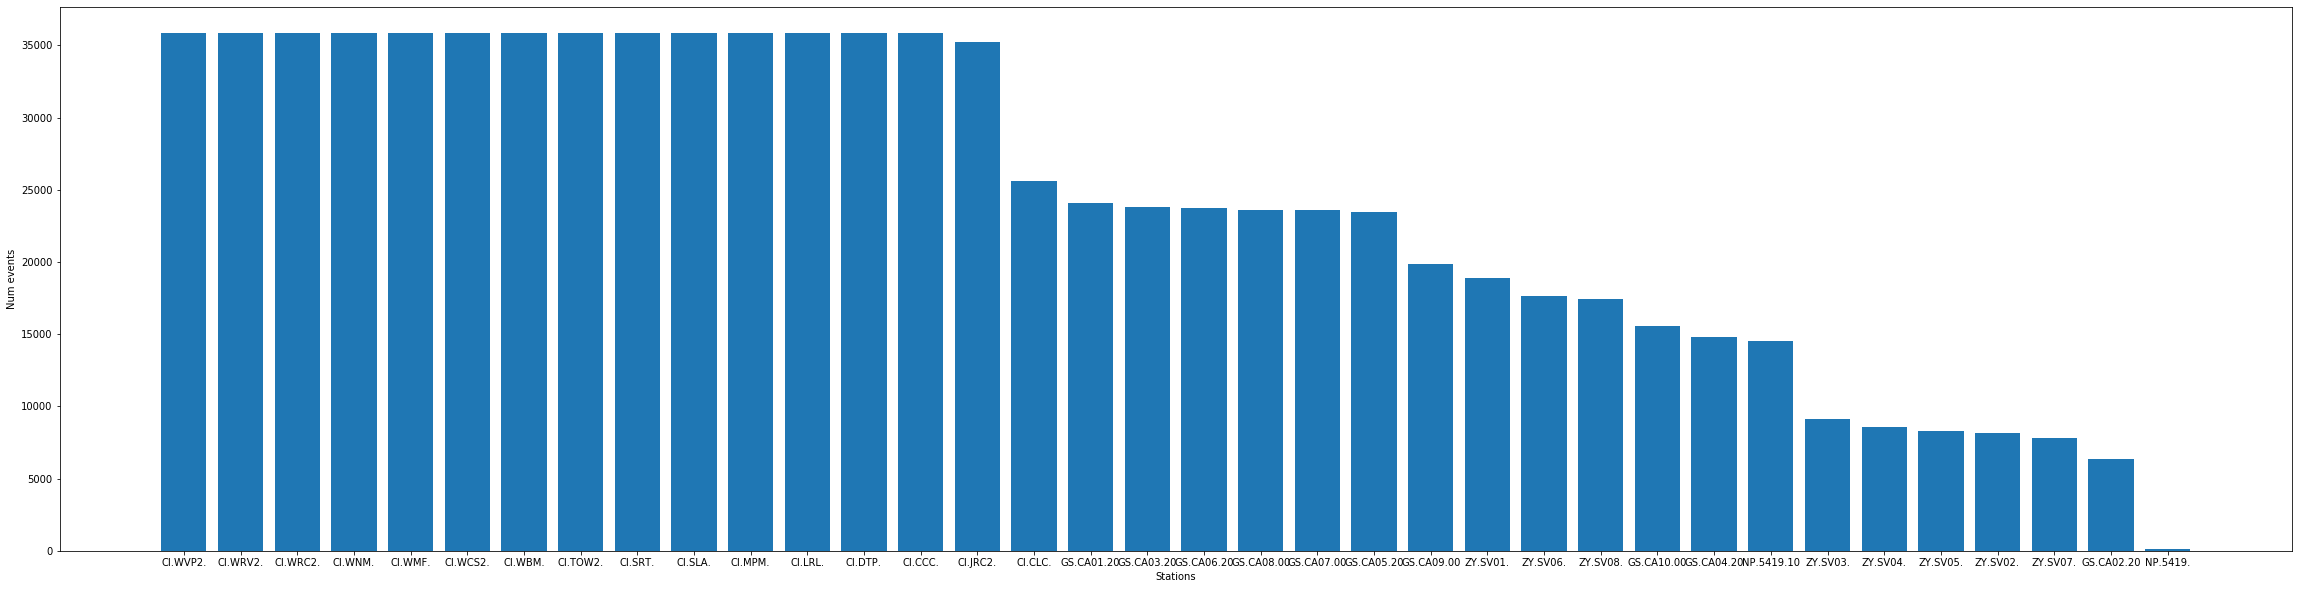

In [33]:
sorted_dict = sorted(zip(list(counts.values()), list(counts.keys())))
sorted_counts, sorted_stats = zip(*sorted_dict)
sorted_counts, sorted_stats = sorted_counts[::-1], sorted_stats[::-1]
plt.figure(figsize=(40,10))
plt.bar(sorted_stats, sorted_counts)
plt.xlabel('Stations'); plt.ylabel("Num events")
plt.show()

In [34]:
with open(os.path.join(meta_path, 'all_station_counts.json'), 'w') as fp:
    json.dump(counts, fp)  

### Step-2: Filter relevant stations

In [4]:
num_stations = 15

with open(os.path.join(meta_path, 'all_station_counts.json')) as json_file:
    stat_counts = json.load(json_file)

print(stat_counts)

{'CI.CCC.': 35858, 'CI.DTP.': 35858, 'CI.JRC2.': 35206, 'CI.LRL.': 35858, 'CI.MPM.': 35858, 'CI.SLA.': 35858, 'CI.SRT.': 35858, 'CI.TOW2.': 35858, 'CI.WBM.': 35858, 'CI.WCS2.': 35858, 'CI.WMF.': 35858, 'CI.WNM.': 35858, 'CI.WRC2.': 35858, 'CI.WRV2.': 35858, 'CI.WVP2.': 35858, 'GS.CA01.20': 24076, 'GS.CA03.20': 23836, 'GS.CA05.20': 23499, 'GS.CA06.20': 23747, 'GS.CA07.00': 23633, 'GS.CA08.00': 23633, 'GS.CA09.00': 19846, 'GS.CA10.00': 15593, 'NP.5419.10': 14526, 'ZY.SV01.': 18914, 'ZY.SV06.': 17628, 'ZY.SV08.': 17451, 'CI.CLC.': 25627, 'GS.CA04.20': 14837, 'ZY.SV02.': 8140, 'ZY.SV03.': 9145, 'ZY.SV04.': 8602, 'GS.CA02.20': 6360, 'ZY.SV05.': 8265, 'ZY.SV07.': 7804, 'NP.5419.': 136}


('CI.WVP2.', 'CI.WRV2.', 'CI.WRC2.', 'CI.WNM.', 'CI.WMF.', 'CI.WCS2.', 'CI.WBM.', 'CI.TOW2.', 'CI.SRT.', 'CI.SLA.', 'CI.MPM.', 'CI.LRL.', 'CI.DTP.', 'CI.CCC.', 'CI.JRC2.')
(35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35206)


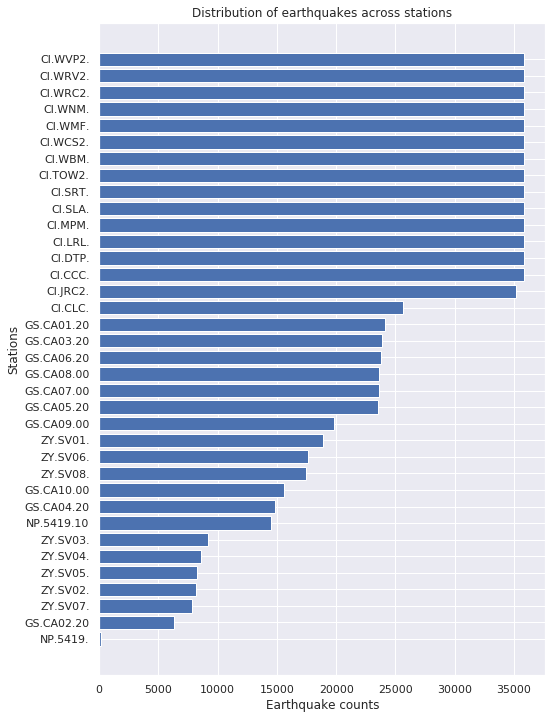

In [5]:
sorted_dict = sorted(zip(list(stat_counts.values()), list(stat_counts.keys())))
sorted_counts, sorted_stats = zip(*sorted_dict)
sorted_counts, sorted_stats = sorted_counts[::-1], sorted_stats[::-1]
# plt.bar(sorted_stats, sorted_counts)
# plt.title("Station event counts")
# plt.show()

master_stations = sorted_stats[:num_stations]
print(master_stations)
print(sorted_counts[:num_stations])

fig, ax = plt.subplots(figsize=(8,12))
# Example data
stats = sorted_stats
station_counts = sorted_counts

y_pos = np.arange(len(stats))

ax.barh(stats, station_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(stats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Earthquake counts')
ax.set_ylabel('Stations')
ax.set_title('Distribution of earthquakes across stations')

plt.show()

In [6]:
## Create array of dates
dates = sorted([entry.name.split(".")[0] for entry in list(os.scandir(raw_path)) if "npy" in entry.name])
# print(sorted(dates))
print(len(dates))

122


In [ ]:
if not os.path.exists(relevant_path):
    os.mkdir(relevant_path)

print("Extracting data for stations: {}".format(master_stations))
np.save(os.path.join(relevant_path, "stations.npy"), master_stations)

dropped_dates = []
ev_count = 0
for date in tqdm(dates):
    date_data = os.path.join(raw_path, date+".npy")
#     print("Loading data from date {}".format(date))
    date_arr = np.load(date_data)
    
    ## look for stations for that day (metadata)
    station_meta = os.path.join(meta_path, date+"_stations.npy")
#     print("\tLoading metadata from {}".format(station_meta))
    date_stations = np.load(station_meta)
#     print("testing", date_stations, master_stations, date_arr)
    delete_date = False
    stats_for_date = []
#     print("\tStations for date {}: {}".format(date, date_stations))

    for master in master_stations: 
        if master not in date_stations: 
            delete_date = True
            break     
#         print(date_stations, master)
        
        # Index date_arr using indices that match master in date_stations
        idx_date = date_arr[date_stations == master]
#         print(idx_date.shape)
#         print(idx)
#         stats_for_date.append(date_arr[idx, :, :,])
        stats_for_date.append(idx_date)

    if delete_date is True: 
        print("\tDeleting date {}".format(date))
        dropped_dates.append(date)
        continue
    stats_for_date = np.concatenate(stats_for_date, 0)
    assert stats_for_date.shape[0] == len(master_stations)
    date_save = os.path.join(relevant_path, "{}.npy".format(date))
    stats_for_date = np.transpose(stats_for_date, [1, 0, 2, 3]) #(num_evs, stats, dim, time)
    stats_for_date = np.linalg.norm(stats_for_date, ord=2, axis=2)
    ev_count += stats_for_date.shape[0]
#     print(stats_for_date.shape)
#     np.save(date_save, stats_for_date)
#     print(stats_for_date.shape)
#     break
print("Dropped dates: ", dropped_dates)
print(ev_count)

  4%|▍         | 5/122 [00:00<00:02, 45.68it/s]

Extracting data for stations: ('CI.WVP2.', 'CI.WRV2.', 'CI.WRC2.', 'CI.WNM.', 'CI.WMF.', 'CI.WCS2.', 'CI.WBM.', 'CI.TOW2.', 'CI.SRT.', 'CI.SLA.', 'CI.MPM.', 'CI.LRL.', 'CI.DTP.', 'CI.CCC.', 'CI.JRC2.')


 34%|███▎      | 41/122 [03:46<44:56, 33.28s/it]

### Step-3: Compress via subsampling

In [38]:
if not os.path.exists(compressed_path):
    os.mkdir(compressed_path)
    
files = [entry.name for entry in os.scandir(relevant_path) if "2019" in entry.name]
print(files)
print(len(files))

WIDTH = 100
quake_counts = 0
for file in files:
    print("Processing file: {}".format(file))
    large = np.load(os.path.join(relevant_path, file))
    print("\tBefore: ", large.shape)
    comp_shape = (large.shape[0], large.shape[1], large.shape[2] // WIDTH)
    compressed = np.zeros(comp_shape)
    for i in range(comp_shape[2]):
        compressed[:, :, i] = np.mean(large[:, :, WIDTH*i: WIDTH*(i+1)], 2)
    print("\tAfter: ", compressed.shape)
    quake_counts += large.shape[0]
#     np.save(os.path.join(compressed_path, file), compressed)
    

['2019-06-12.npy', '2019-08-25.npy', '2019-07-31.npy', '2019-07-02.npy', '2019-07-07.npy', '2019-07-19.npy', '2019-07-17.npy', '2019-08-15.npy', '2019-08-04.npy', '2019-06-10.npy', '2019-08-10.npy', '2019-06-26.npy', '2019-09-30.npy', '2019-08-26.npy', '2019-09-13.npy', '2019-06-29.npy', '2019-08-13.npy', '2019-07-26.npy', '2019-07-21.npy', '2019-06-08.npy', '2019-07-15.npy', '2019-09-06.npy', '2019-09-11.npy', '2019-09-26.npy', '2019-06-04.npy', '2019-08-16.npy', '2019-07-18.npy', '2019-08-05.npy', '2019-07-08.npy', '2019-09-20.npy', '2019-08-12.npy', '2019-07-13.npy', '2019-09-16.npy', '2019-06-03.npy', '2019-06-30.npy', '2019-07-14.npy', '2019-07-22.npy', '2019-08-27.npy', '2019-07-25.npy', '2019-08-22.npy', '2019-06-19.npy', '2019-08-31.npy', '2019-08-11.npy', '2019-06-06.npy', '2019-06-27.npy', '2019-07-06.npy', '2019-06-07.npy', '2019-06-20.npy', '2019-08-24.npy', '2019-08-20.npy', '2019-09-23.npy', '2019-08-14.npy', '2019-06-16.npy', '2019-08-28.npy', '2019-09-29.npy', '2019-06-

In [39]:
print(quake_counts)

35679


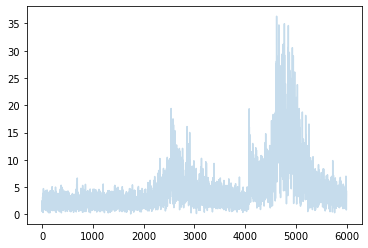

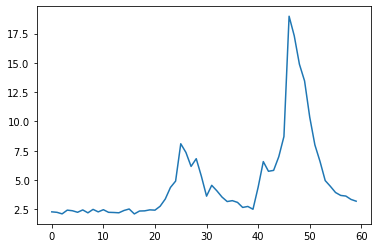

In [80]:
test_date = "2019-07-06.npy"
test_original = np.load(os.path.join(relevant_path, test_date))
test_compressed = np.load(os.path.join(compressed_path, test_date))

plt.plot(test_original[0, 0, :], alpha=0.25)
plt.show()
plt.plot(test_compressed[0, 0, :])
plt.show()